In [1]:
import os
os.chdir("/Users/ieo5776/Desktop/signal_processing_course/")
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.signal
import scipy.io
from tools import denoise
import copy

# Convolution and FIR filters
In the provided dataset, there's the original signal, a signal filtered with FIR and a signal convolved with a morlet wavelet.

The idea is to figure out a way to reproduce them

# Solution

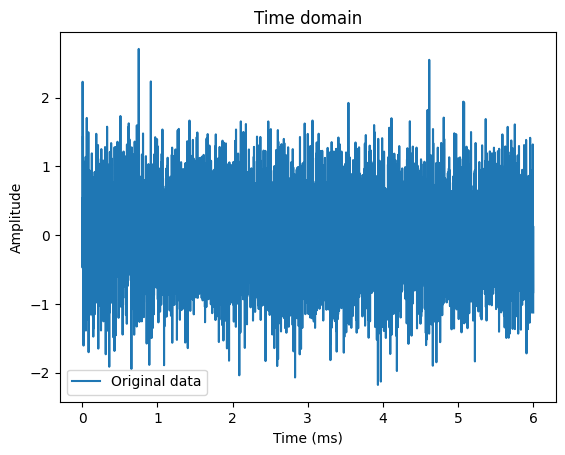

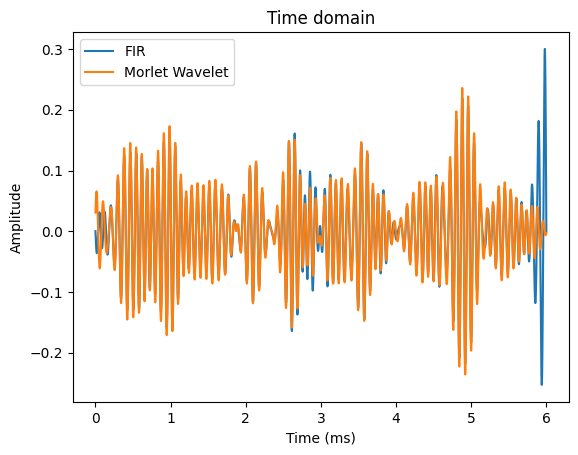

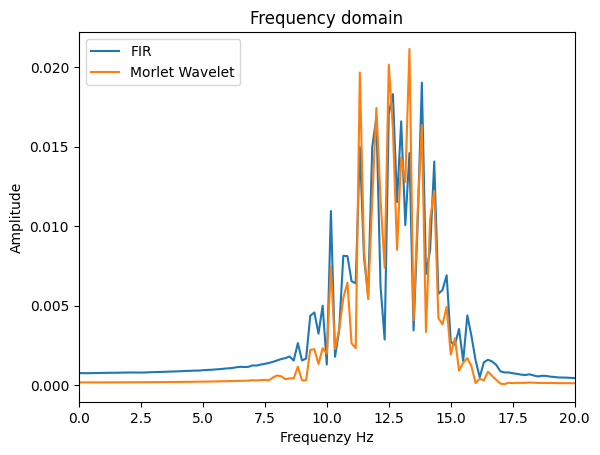

In [97]:
mat = scipy.io.loadmat("SignalProcessing/wavelet/wavelet_codeChallenge.mat")
signal_original = mat['signal'][:,0]
signal_FIR = mat['signalFIR'][:,0]
signal_MW = mat['signalMW'][:,0]
srate = mat['srate'][:,0]
timevec = np.arange(0, len(signal_original))/srate

# Time domain original
plt.plot(timevec, signal_original, label="Original data")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Time domain")
plt.show()

# Time domain filter signals
plt.plot(timevec, signal_FIR, label="FIR")
plt.plot(timevec, signal_MW, label="Morlet Wavelet")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Time domain")
plt.show()

# Amplitude spectra
hz = np.linspace(0,srate/2,int(np.floor(len(signal_FIR)/2)+1))
pwr_FIR = np.abs(scipy.fftpack.fft(signal_FIR))/1e4
pwr_MW = np.abs(scipy.fftpack.fft(signal_MW))/1e4

# I don't know why i have to divide the amplitude by 1e4 to get the same results
# of the exercise. It's definetly some kind of normalization, but i'm not getting it now.
plt.plot(hz, pwr_FIR[0:len(hz)], label="FIR")
plt.plot(hz, pwr_MW[0:len(hz)], label="Morlet Wavelet")
plt.legend()
plt.xlabel("Frequenzy Hz")
plt.ylabel("Amplitude")
plt.title("Frequency domain")
plt.xlim(0, 20)
plt.show()

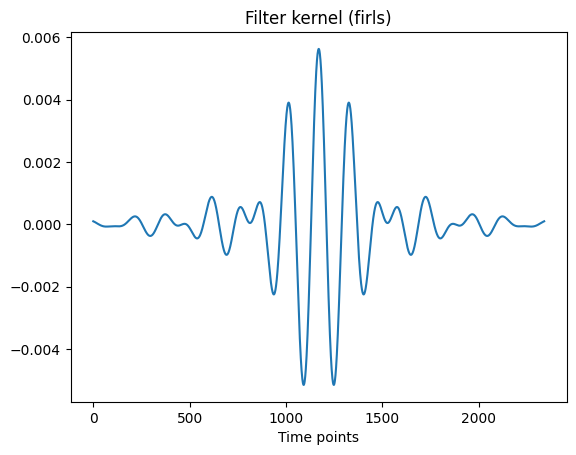

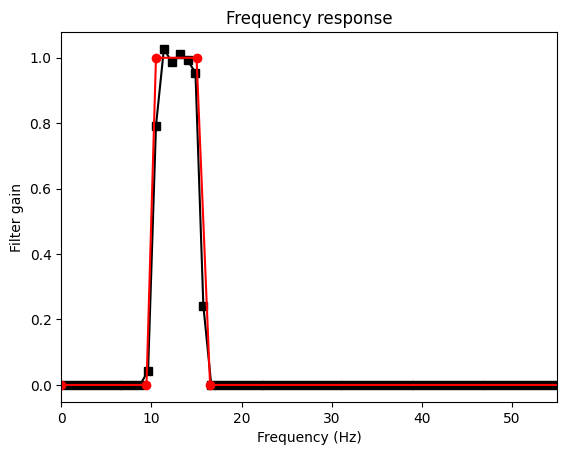

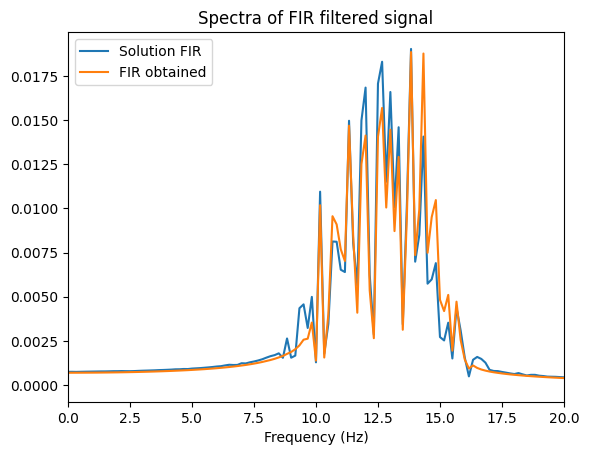

In [92]:
# Let's start with an FIR filter, bandpass filter between ~8 and 16
lbound = 10.5
hbound = 15
transw= .1

order = 12*np.round((int(srate)/lbound))+1

filter_shape = [0,0,1,1,0,0]
filter_freqs = [0, lbound*(1-transw), lbound, hbound, hbound+hbound*transw, int(srate/2)]

filterkernel = scipy.signal.firls(order, filter_freqs, filter_shape, fs=int(srate))
hz_kernel = np.linspace(0, srate/2, int(np.floor(len(filterkernel)/2)+1))
kernel_pow = np.abs(scipy.fftpack.fft(filterkernel))**2

## plots
plt.plot(filterkernel)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')
plt.show()

# plot amplitude spectrum of the filter kernel
plt.plot(hz_kernel,kernel_pow[:len(hz_kernel)],'ks-')
plt.plot(filter_freqs,filter_shape,'ro-')
plt.xlim([0,hbound+40])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.title('Frequency response')
plt.show()


# Filter the signal
filter_signal = scipy.signal.filtfilt(filterkernel, 1, signal_original)
spectra_FIR = np.abs(scipy.fftpack.fft(filter_signal))/1e4

# Plot
plt.plot(hz,pwr_FIR[0:len(hz)],label='Solution FIR')
plt.plot(hz,spectra_FIR[0:len(hz)],label='FIR obtained')
plt.xlim([0,80])
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.xlim(0, 20)
plt.title('Spectra of FIR filtered signal')
plt.show()


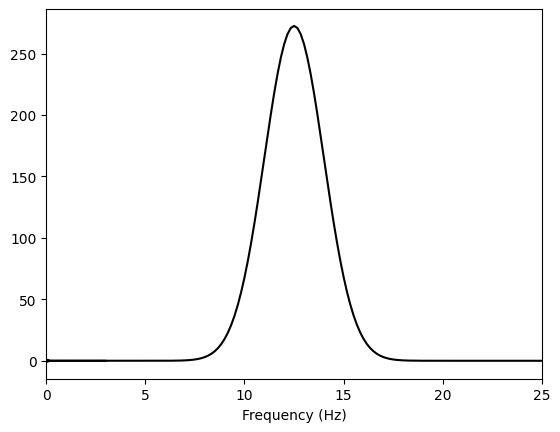

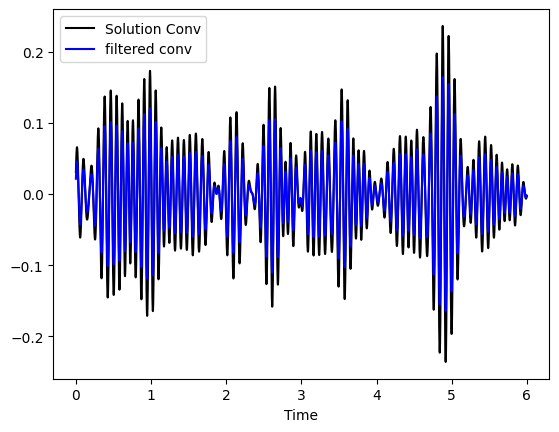

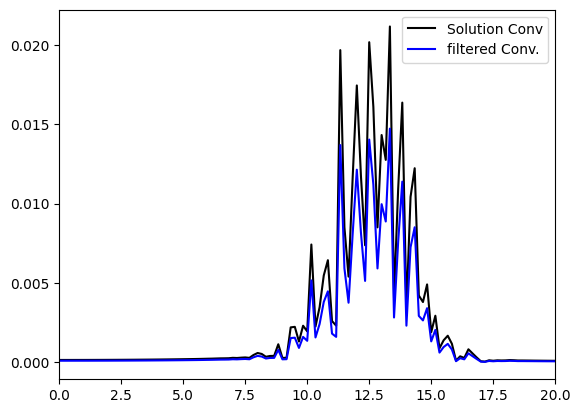

In [98]:
# Now let's do it with a morlet wavelet

# create a morlet wavelet with a frequnzy peak at ~ 12.5
ffreq = 12.5
fwhm= .25
wavtime = np.arange(-3,3, 1/srate)

# create wavelet
morWave = np.cos(2*np.pi*ffreq*wavtime) * np.exp( -(4*np.log(2)*wavtime**2) / fwhm**2)

# amplitude spectrum of the morlet wavelet
hz_morlet = np.linspace(0, srate/2, int(np.floor(len(wavtime)/2)+1))
pwr_mortlet = np.abs(scipy.fftpack.fft(morWave))

# plot it!
plt.plot(wavtime,morWave,'k')
plt.xlim([-2,2])
plt.xlabel('Time (sec.)')

plt.plot(hz_morlet,pwr_mortlet[:len(hz_morlet)],'k')
plt.xlim([0,ffreq*2])
plt.xlabel('Frequency (Hz)')
plt.show()

# Convolution
nconvs = len(signal_original) + len(wavtime) -1
halfw = int(np.floor(len(wavtime)/2))

# Spectrum wavelet
morwaveSpect = scipy.fftpack.fft(morWave, nconvs) # do not take the np.abs
morwaveSpect = morwaveSpect / np.abs(np.max(morwaveSpect))

convres = scipy.fftpack.ifft( morwaveSpect * scipy.fftpack.fft(signal_original, nconvs))
convres = np.real(convres[halfw:-halfw+1])

# time domain
plt.plot(timevec,signal_MW,'k',label='Solution Conv')
plt.plot(timevec,convres,'b',label='filtered conv')
plt.legend()
plt.xlabel('Time')
plt.show()

# frequency domain
convresX = np.abs(scipy.fftpack.fft(convres))/1e4
plt.plot(hz,pwr_MW[:len(hz)],'k',label='Solution Conv')
plt.plot(hz,convresX[:len(hz)],'b',label='filtered Conv.')
plt.xlim([0,20])
plt.legend()
plt.show()


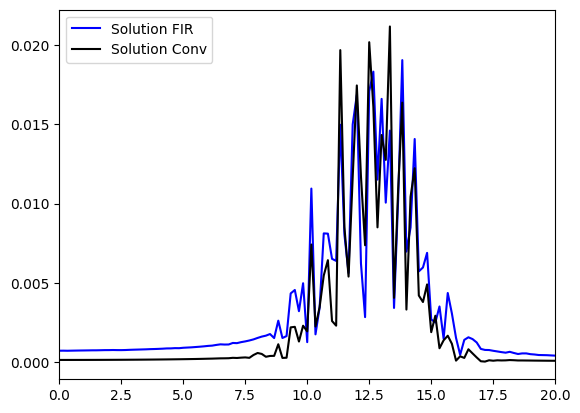

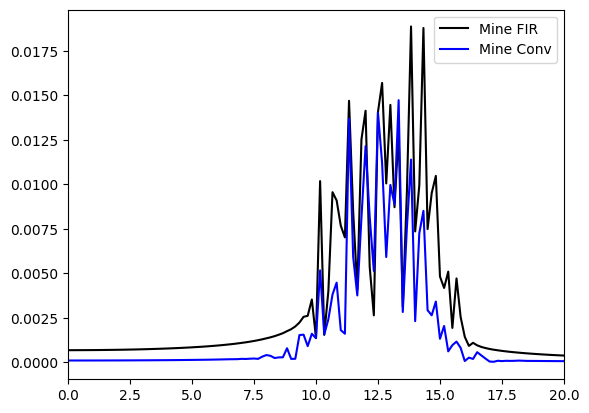

In [96]:
# Plot the given results and my results
plt.plot(hz,pwr_FIR[:len(hz)],'b',label='Solution FIR')
plt.plot(hz,pwr_MW[:len(hz)],'k',label='Solution Conv')
plt.xlim([0,20])
plt.legend()
plt.show()

plt.plot(hz,spectra_FIR[:len(hz)],'k',label='Mine FIR')
plt.plot(hz,convresX[:len(hz)],'b',label='Mine Conv')
plt.xlim([0,20])
plt.legend()
plt.show()